In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer



In [2]:
# Read datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [3]:
print("Training Data:")
print(train_data.head())
print(train_data.info())
print(train_data.describe())

Training Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   Na

In [4]:
print("\nTest Data:")
print(test_data.head())
print(test_data.info())
print(test_data.describe())


Test Data:
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       

In [5]:
print("\nGender Submission Data:")
print(gender_submission.head())
print(gender_submission.info())
print(gender_submission.describe())


Gender Submission Data:
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB
None
       PassengerId    Survived
count   418.000000  418.000000
mean   1100.500000    0.363636
std     120.810458    0.481622
min     892.000000    0.000000
25%     996.250000    0.000000
50%    1100.500000    0.000000
75%    1204.750000    1.000000
max    1309.000000    1.000000


In [6]:
# Data Cleaning:
# Convert 'SibSp' and 'Parch' columns to numeric before creating the 'Family_Size' feature
train_data['SibSp'] = pd.to_numeric(train_data['SibSp'], errors='coerce')
train_data['Parch'] = pd.to_numeric(train_data['Parch'], errors='coerce')

# Repeat for the 'test_data' dataset
test_data['SibSp'] = pd.to_numeric(test_data['SibSp'], errors='coerce')
test_data['Parch'] = pd.to_numeric(test_data['Parch'], errors='coerce')

# Create a new feature 'Family_Size' after converting 'SibSp' and 'Parch' to numeric
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch']
test_data['Family_Size'] = test_data['SibSp'] + test_data['Parch']

# Create age groups
bins = [0, 12, 18, 35, 60, 100]
labels = ['Child', 'Teenager', 'Adult', 'Middle-aged', 'Senior']
train_data['Age_Group'] = pd.cut(train_data['Age'], bins=bins, labels=labels)
test_data['Age_Group'] = pd.cut(test_data['Age'], bins=bins, labels=labels)

# Extract deck information from the Cabin column
train_data['Deck'] = train_data['Cabin'].str.slice(0, 1)
test_data['Deck'] = test_data['Cabin'].str.slice(0, 1)

# Extract ticket prefixes
train_data['Ticket_Prefix'] = train_data['Ticket'].apply(lambda x: x.split(' ')[0] if len(x.split(' ')) > 1 else 'No_Prefix')
test_data['Ticket_Prefix'] = test_data['Ticket'].apply(lambda x: x.split(' ')[0] if len(x.split(' ')) > 1 else 'No_Prefix')

# Calculate fare per person
train_data['Fare_Per_Person'] = train_data['Fare'] / (train_data['Family_Size'] + 1)
test_data['Fare_Per_Person'] = test_data['Fare'] / (test_data['Family_Size'] + 1)


In [7]:
# Additional Feature Engineering:
# 1. Title from Name
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 2. Is Alone
train_data['Is_Alone'] = (train_data['Family_Size'] == 0).astype(int)
test_data['Is_Alone'] = (test_data['Family_Size'] == 0).astype(int)

# 3. Age * Class
train_data['Age_Class'] = train_data['Age'] * train_data['Pclass']
test_data['Age_Class'] = test_data['Age'] * test_data['Pclass']

# 4. Fare * Family Size
train_data['Fare_Family'] = train_data['Fare'] * (train_data['Family_Size'] + 1)
test_data['Fare_Family'] = test_data['Fare'] * (test_data['Family_Size'] + 1)

# 5. Cabin Type
train_data['Cabin_Type'] = train_data['Cabin'].str.slice(0, 1)
test_data['Cabin_Type'] = test_data['Cabin'].str.slice(0, 1)

# 6. Ticket Length
train_data['Ticket_Length'] = train_data['Ticket'].apply(lambda x: len(x))
test_data['Ticket_Length'] = test_data['Ticket'].apply(lambda x: len(x))

c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureW

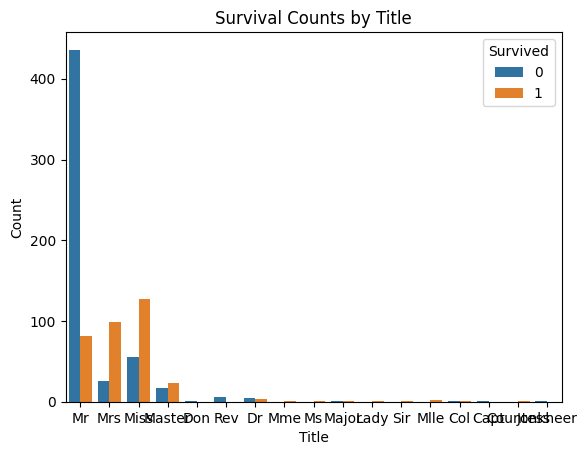

c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureW

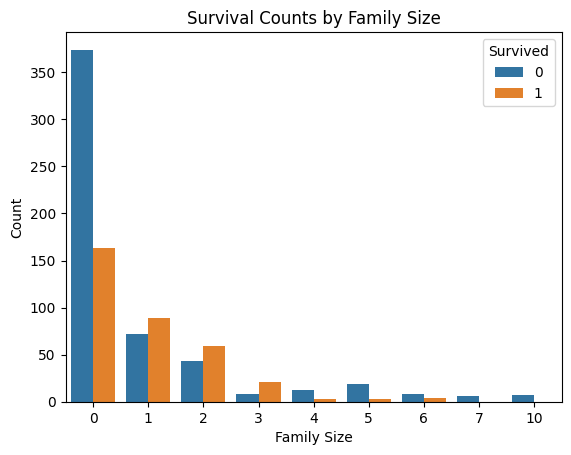

c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 

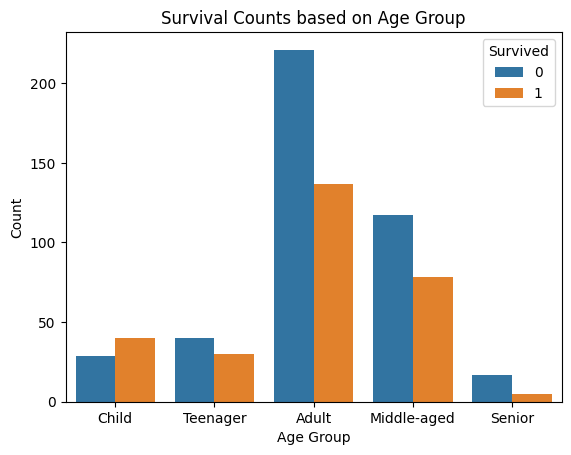

c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureW

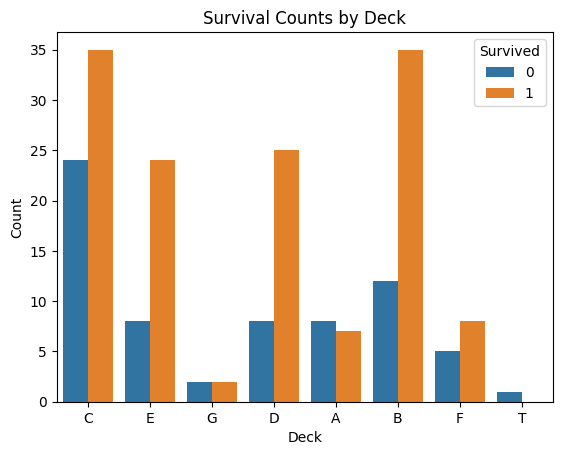

c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureW

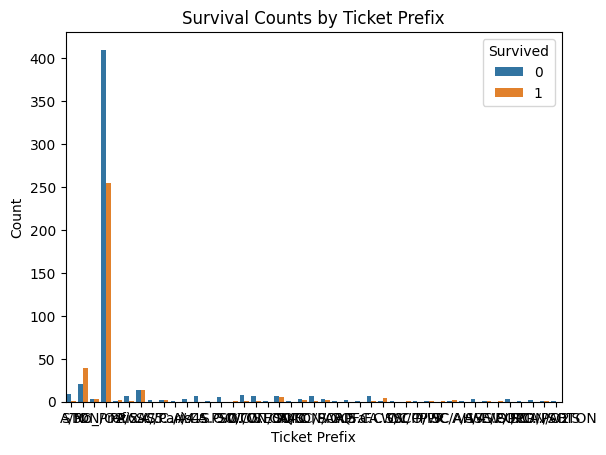

c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureW

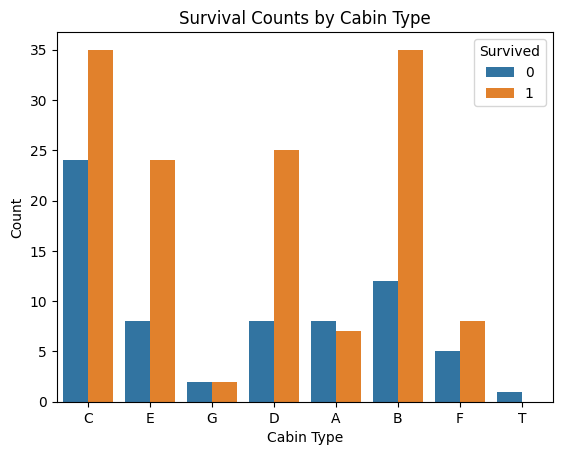

c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Khushboo Joshi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


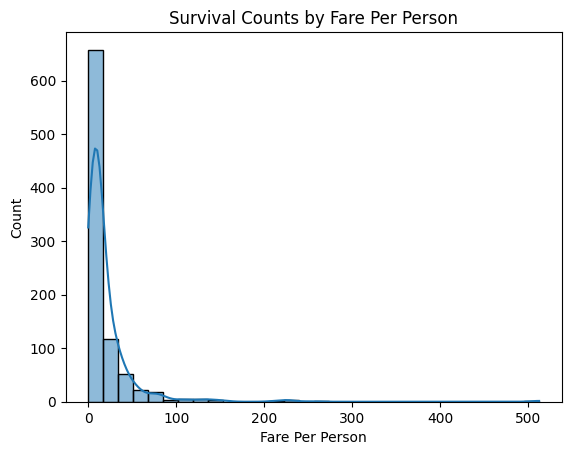

In [8]:
# Optional: Data Analysis and Visualization
# Visualize survival counts by title
sns.countplot(x='Title', hue='Survived', data=train_data)
plt.title('Survival Counts by Title')
plt.xlabel('Title')
plt.ylabel('Count')
plt.show()

# Visualize survival counts by family size
sns.countplot(x='Family_Size', hue='Survived', data=train_data)
plt.title('Survival Counts by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Count')
plt.show()

# Visualize survival counts by age group
sns.countplot(x='Age_Group', hue='Survived', data=train_data)
plt.title('Survival Counts based on Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

# Visualize survival counts by deck
sns.countplot(x='Deck', hue='Survived', data=train_data)
plt.title('Survival Counts by Deck')
plt.xlabel('Deck')
plt.ylabel('Count')
plt.show()

# Visualize survival counts by ticket prefix
sns.countplot(x='Ticket_Prefix', hue='Survived', data=train_data)
plt.title('Survival Counts by Ticket Prefix')
plt.xlabel('Ticket Prefix')
plt.ylabel('Count')
plt.show()

# Visualize survival counts by cabin type
sns.countplot(x='Cabin_Type', hue='Survived', data=train_data)
plt.title('Survival Counts by Cabin Type')
plt.xlabel('Cabin Type')
plt.ylabel('Count')
plt.show()

# Visualize survival counts by fare per person
sns.histplot(train_data['Fare_Per_Person'], bins=30, kde=True)
plt.title('Survival Counts by Fare Per Person')
plt.xlabel('Fare Per Person')
plt.ylabel('Count')
plt.show()



In [9]:
# Define features including the new ones
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Age_Group', 'Deck', 'Ticket_Prefix', 'Fare_Per_Person',
'Title', 'Is_Alone', 'Age_Class', 'Fare_Family', 'Cabin_Type', 'Ticket_Length']
# Create feature matrix (X) and target vector (y)
X = pd.get_dummies(train_data[features])
y = train_data['Survived']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
# Try different machine learning models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model:")
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Model evaluation
    print("\nModel Evaluation:")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Perform hyperparameter tuning (Example with Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier()
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"\nBest Hyperparameters: {best_params}")

# Evaluate the model with the best hyperparameters
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_val)

# Model evaluation for the best model
print("\nBest Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred_best))
print("\nClassification Report:\n", classification_report(y_val, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_best))



Training Logistic Regression model:

Model Evaluation:
Accuracy: 0.7988826815642458

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       105
           1       0.76      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix:
 [[87 18]
 [18 56]]

Training Random Forest model:

Model Evaluation:
Accuracy: 0.8044692737430168

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix:
 [[90 15]
 [20 54]]

Training Support Vector Machine model:



Model Evaluation:
Accuracy: 0.8268156424581006

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179


Confusion Matrix:
 [[92 13]
 [18 56]]

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Best Model Evaluation:
Accuracy: 0.8044692737430168

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix:
 [[92 13]
 [22 52]]
